# Import Dependencies

In [1]:
import codecs
import glob
import multiprocessing
import os
import pprint
import re

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Prepare Corpus

In [2]:
# Look harry porter books
book_filenames = sorted(glob.glob('../harry_poter_books/*.txt'))

# Combine books in one string
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print ""
    
# Tokenize into sentences
tokenized_sentences = sent_tokenize(corpus_raw)

print len(tokenized_sentences)


Reading '../harry_poter_books/book1.txt'...
Corpus is now 446557 characters long

Reading '../harry_poter_books/book2.txt'...
Corpus is now 947314 characters long

Reading '../harry_poter_books/book3.txt'...
Corpus is now 1581110 characters long

Reading '../harry_poter_books/book4.txt'...
Corpus is now 2701667 characters long

Reading '../harry_poter_books/book5.txt'...
Corpus is now 4216190 characters long

Reading '../harry_poter_books/book6.txt'...
Corpus is now 5215791 characters long

62576


### Tokenized sentences

In [3]:
#convert into a list of words
#remove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

#sentence where each word is tokenized
sentences = []
for raw_sentence in tokenized_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))
        


In [4]:

print(tokenized_sentences[5])
print(sentence_to_wordlist(tokenized_sentences[5]))

The Dursleys 
had a small son called Dudley and in their opinion there was no finer boy anywhere.
[u'The', u'Dursleys', u'had', u'a', u'small', u'son', u'called', u'Dudley', u'and', u'in', u'their', u'opinion', u'there', u'was', u'no', u'finer', u'boy', u'anywhere']


In [5]:
#count total number of sentences
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 918,059 tokens


In [6]:
# Train word2Vec
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 15

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()
# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

# Create and Train word2vec Model

In [7]:
# if sg = 1 then CBOW is used else skip-gram model
harryPorter2vec = w2v.Word2Vec(sentences,
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)


### Save word2vec model

In [8]:
# harryPorter2vec.build_vocab(sentences)
model_name = "PotterTrainedModel"
harryPorter2vec.save(model_name)

# load saved model

In [9]:
new_model = w2v.Word2Vec.load('PotterTrainedModel')

In [10]:
#list vocabulary
vocab = list(new_model.wv.vocab.keys())
print vocab[:160]

[u'exams', u'incantation', u'hats', u'personally', u'crumpled', u'yellow', u'sleek', u'four', u'Does', u'sleep', u'spiders', u'hanging', u'hate', u'pack', u'marching', u'trolley', u'whose', u'patches', u'swam', u'Diggory', u'containing', u'presents', u'slipping', u'whatsoever', u'under', u'teaching', u'sorry', u'pride', u'worth', u'Avada', u'placed', u'fists', u'Extendable', u'enonnous', u'louder', u'risk', u'rise', u'every', u'foul', u'utmost', u'bringing', u'vast', u'look', u'tickets', u'school', u'bewildered', u'wooden', u'Nice', u'frozen', u'Shacklebolt', u'red', u'greenish', u'Go', u'heading', u'triumph', u'clothes', u'enjoy', u'Leanne', u'Merlin', u'force', u'completely', u'tired', u'awake', u'feathers', u'Weasley', u'surrounding', u'likely', u'street', u'shrugging', u'air', u'quill', u'shining', u'blue', u'hide', u'Gilderoy', u'forgetting', u'painful', u'saved', u'cooking', u'Mudbloods', u'fingers', u'poison', u'lights', u'above', u'sideways', u'Put', u'new', u'tips', u'Sorcerer

In [11]:
len(new_model['Tuesday'])

/home/ramesh/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


300

In [12]:
new_model.wv.most_similar('Tuesday', topn=15)

[(u'Day', 0.9117708206176758),
 (u'Wednesday', 0.9087163209915161),
 (u'Friday', 0.8807086944580078),
 (u'Today', 0.8695257306098938),
 (u'weekend', 0.8683939576148987),
 (u'June', 0.8682065606117249),
 (u'September', 0.867559552192688),
 (u'Monday', 0.8658707141876221),
 (u'yesterday', 0.8653514385223389),
 (u'trip', 0.8640763163566589),
 (u'finishing', 0.8614814877510071),
 (u'practices', 0.8610953092575073),
 (u'marked', 0.8561346530914307),
 (u'Last', 0.8556561470031738),
 (u'Easter', 0.8534767627716064)]

# Plot using TSNE

/home/ramesh/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/home/ramesh/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


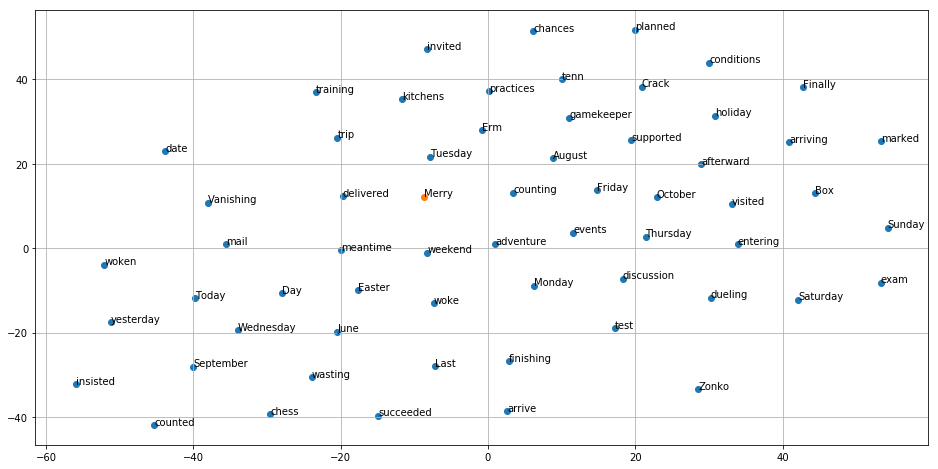

In [13]:
def TSNEPlot(model, word, dimension):
    
    #Empty vector, to append embeddings of closer/similar words
    embeddings_vector = np.empty((0,dimension), dtype='f')
    
    related_words = []
    related_words.append(word)
    queried_word_vector = (model[word])
    queried_word_vector = queried_word_vector.reshape(1,300)
    get_similar_words = model.wv.most_similar(word, topn=60)
    embeddings_vector = np.append(embeddings_vector, queried_word_vector, axis=0)
    
    for sim_word in get_similar_words:
        word = sim_word[0]
        word_vector = model[word]
        related_words.append(word)
        word_vector = word_vector.reshape(1,300)
        embeddings_vector = np.append(embeddings_vector, word_vector, axis=0)
    
    # Reduce 300 dimension into two dimension and do scatter plotting
    tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
    Y = tsne.fit_transform(embeddings_vector)
    plt.figure(figsize=(16,8))
    x_coords = Y[1:, 0]
    y_coords = Y[1:, 1]
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(related_words, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.scatter([Y[0, 0]], [Y[0,1]])
    plt.annotate(word, xy=(Y[0,0], Y[0,1]), xytext=(0, 0), textcoords='offset points')
    plt.grid(True)
    plt.show()
    
new_model = w2v.Word2Vec.load('PotterTrainedModel')
TSNEPlot(new_model, 'Tuesday', dimension = 300)